Problema del negocio: 
Mejorar la experiencia de los clientes que permita su fidelización en la plataforma online. Ademas de lograr ser recomendada a nuevos clientes. 
Problema análitico:
Realizar un sistema de recomendación para los usuarios y una plataforma online. 

IMPORTAR PAQUETES

In [4]:
#Importar paquetes
import pandas as pd
import numpy as np
import sqlite3 as sql
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from ipywidgets import interact
import os  ### para ver y cambiar directorio de trabajo
os.getcwd()

'c:\\Users\\anita\\OneDrive\\Escritorio\\Universidad\\2022-1\\Aplicación de la analítica\\Marketing\\AnaliticaIII-Marketing'

In [5]:
#Para ejecutar sql y conectarse a bd #
conn=sql.connect('db_movies')
cur=conn.cursor() ###para funciones que ejecutan sql en base de datos

In [6]:
#Función
def ejecutar_sql (nombre_archivo, cur):
    sql_file=open(nombre_archivo)
    sql_as_string=sql_file.read()
    sql_file.close
    cur.executescript(sql_as_string)

CARGA DE DATOS

In [7]:
#Cargar tablas
movies= pd.read_sql('select * from movies', conn)
ratings = pd.read_sql('select * from ratings', conn)

Tabla Movies

In [8]:
#Ver los primeros 5 datos de la tabla movies
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
#Observar columnas de movies
print('Columnas:',movies.columns)
#Dimensiones de la base
print('Dimensiones:', movies.shape)

Columnas: Index(['movieId', 'title', 'genres'], dtype='object')
Dimensiones: (9742, 3)


In [10]:
#Conocer el tipo de variables
print(movies.dtypes)

movieId     int64
title      object
genres     object
dtype: object


In [11]:
#Información general
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Tabla Ratings

In [12]:
#Ver primeros cinco datos de la tabla ratings
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
#Información general
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [14]:
#Observar columnas de movies
print('Columnas:',ratings.columns)
#Dimensiones de la base
print('Dimensiones:', ratings.shape)

Columnas: Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Dimensiones: (100836, 4)


In [15]:
#Conocer el tipo de variables
print(ratings.dtypes)

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object


In [16]:
#Ejemplo de cambio de formato de timestamp a datetime
from datetime import datetime
datetime.fromtimestamp(964982703)

datetime.datetime(2000, 7, 31, 4, 45, 3)

In [17]:
#Modificar formato de timestamp a datetime
from datetime import datetime
ratings['timestamp']= ratings.apply(lambda x: datetime.fromtimestamp(x['timestamp']), axis=1)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000-07-31 04:45:03
1,1,3,4.0,2000-07-31 04:20:47
2,1,6,4.0,2000-07-31 04:37:04
3,1,47,5.0,2000-07-31 05:03:35
4,1,50,5.0,2000-07-31 04:48:51


Nueva base de datos

In [18]:
#Crear base de datos con la unión de las tablas de movies y ratings
movie_ratings = pd.merge(ratings,movies, how="left", right_on="movieId", left_on="movieId")
movie_ratings.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,2000-07-31 05:03:35,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,2000-07-31 04:48:51,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [19]:
#Información general de la nueva base de datos
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100836 non-null  int64         
 1   movieId    100836 non-null  int64         
 2   rating     100836 non-null  float64       
 3   timestamp  100836 non-null  datetime64[ns]
 4   title      100836 non-null  object        
 5   genres     100836 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 5.4+ MB


In [20]:
#Verificar si hay datos duplicados 
movie_ratings.duplicated().sum()

0

In [21]:
#Observar columnas de la nueva base de datos
movie_ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres'], dtype='object')

BASE DE DATOS CON DUMMIES

In [22]:
#Crear base de datos con variables dummies del campo genero 
genres = movies.copy()
genres = genres.drop(columns=['movieId', 'title'])
genres['genres'] = genres['genres'].str.split('|')
genres_dummies = pd.get_dummies(pd.DataFrame(genres['genres'].tolist()).stack()).sum(level=0)
genres = pd.concat([genres, genres_dummies], axis=1).drop(columns=['genres'])
genres

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
#Concatenar la base de datos movies con la base de datos de los generos de peliculas (dummies)
movies2 = pd.concat([movies, genres], axis=1)
movies2 = movies2.drop(['genres'], axis=1)
movies2.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
#Base de datos con variables de movieid y title
movies3 = pd.melt(movies2, id_vars= ['movieId', 'title'])
print(movies3.columns)

Index(['movieId', 'title', 'variable', 'value'], dtype='object')


In [25]:
#Mostrar los primeros 10 datos de movies3
movies3.sample(10)

,movieId,title,variable,value
40894,2554,Children of the Damned (1963),Children,0
83107,8373,"Stepford Wives, The (2004)",Drama,0
2703,3626,8 ½ Women (a.k.a. 8 1/2 Women) (a.k.a. Eight a...,(no genres listed),0
25472,36537,Thumbsucker (2005),Adventure,0
118331,1950,In the Heat of the Night (1967),IMAX,0
153020,63239,Cinderella (1997),Romance,1
122455,26693,It (1990),IMAX,0
173268,88356,"Smurfs, The (2011)",Thriller,0
174890,157340,The Angry Birds Movie (2016),Thriller,0
89046,1870,"Dancer, Texas Pop. 81 (1998)",Fantasy,0


In [26]:
#Juntas bases de datos de movies con dummies y ratings 
movie_ratings1 = pd.merge(ratings,movies2, how="left", right_on="movieId", left_on="movieId")
movie_ratings1

,userId,movieId,rating,timestamp,title,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-31 04:45:03,Toy Story (1995),0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-31 04:20:47,Grumpier Old Men (1995),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-31 04:37:04,Heat (1995),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-31 05:03:35,Seven (a.k.a. Se7en) (1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-31 04:48:51,"Usual Suspects, The (1995)",0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,2017-05-04 07:53:22,Split (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
100832,610,168248,5.0,2017-05-04 08:21:31,John Wick: Chapter Two (2017),0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
100833,610,168250,5.0,2017-05-09 05:50:47,Get Out (2017),0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
100834,610,168252,5.0,2017-05-04 07:19:12,Logan (2017),0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


ANÁLISIS EXPLORATORIO

In [27]:
#Instalación de paquetes
pip install plotly
pip install nbformat

SyntaxError: invalid syntax (2034314683.py, line 2)

In [ ]:
#Importar paquetes
import plotly.graph_objs as go #Graficos
import plotly.express as px
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt ### gráficos

In [ ]:
#Tabla con el valor de cada genero
movies3.groupby('variable')[['value']].sum().reset_index()

,variable,value
0,(no genres listed),34.0
1,Action,1828.0
2,Adventure,1263.0
3,Animation,611.0
4,Children,664.0
5,Comedy,3756.0
6,Crime,1199.0
7,Documentary,440.0
8,Drama,4361.0
9,Fantasy,779.0


In [ ]:
# crear dataset
base = movie_ratings.groupby(['title'])[['rating']].count().sort_values('rating', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.bar(base, x = 'title', y='rating',
             title= '<b>Películas más calificadas<b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    xaxis_title = 'Películas',
    yaxis_title = 'Calificación',
    template = 'simple_white',
    title_x = 0.5)



(array([ 8791., 10332.,  8003.,  8822., 10673.,  8590., 11151., 12109.,
         6309., 16056.]),
 array([  1. ,  61.9, 122.8, 183.7, 244.6, 305.5, 366.4, 427.3, 488.2,
        549.1, 610. ]),
 <BarContainer object of 10 artists>)

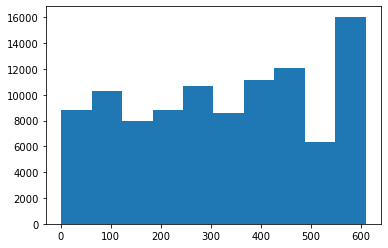

In [ ]:
#Histograma
plt.hist(movie_ratings['userId'])

In [ ]:
#Crear dataset
base = movies3.groupby(['variable'])[['value']].sum().sort_values('value', ascending = False).reset_index().head(10)

# crear gráfica
fig = px.pie(base, values = 'value', names ='variable',
             title= '<b>Porcentaje de los 10 generos de películas más vistos <b>',
             color_discrete_sequence=px.colors.qualitative.G10)

# agregar detalles a la gráfica
fig.update_layout(
    template = 'simple_white',
    title_x = 0.5)

fig.show()

SISTEMAS DE RECOMENDACIÓN

Sistema de recomendación colaborativo por elemento

In [ ]:
#Crear dataset
#Matriz de los usuarios que calificaron peliculas
data1 = movie_ratings.pivot(index='movieId',columns='userId',values='rating')
data1 = data1.fillna(0)
data1

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#saber cuantas calificaciones tiene cada pelicula
usuariovotos = movie_ratings.groupby('movieId')['rating'].agg('count')
#saber cuantas veces han calificado cada película
peliculavotos = movie_ratings.groupby('userId')['rating'].agg('count')

In [ ]:
#Maximo de votaciones de peliculas
print(usuariovotos.max())
#Minimo de votaciones de peliculas
print(peliculavotos.min())

329
20


In [ ]:
#Imprimir el numero de votos minimo por usuario
print(usuariovotos.min())
#Imprimir el numero de votos maximo por usuario
print(peliculavotos.max())

1
2698


<AxesSubplot:title={'center':'Ratings por usuario'}, ylabel='Ratings'>

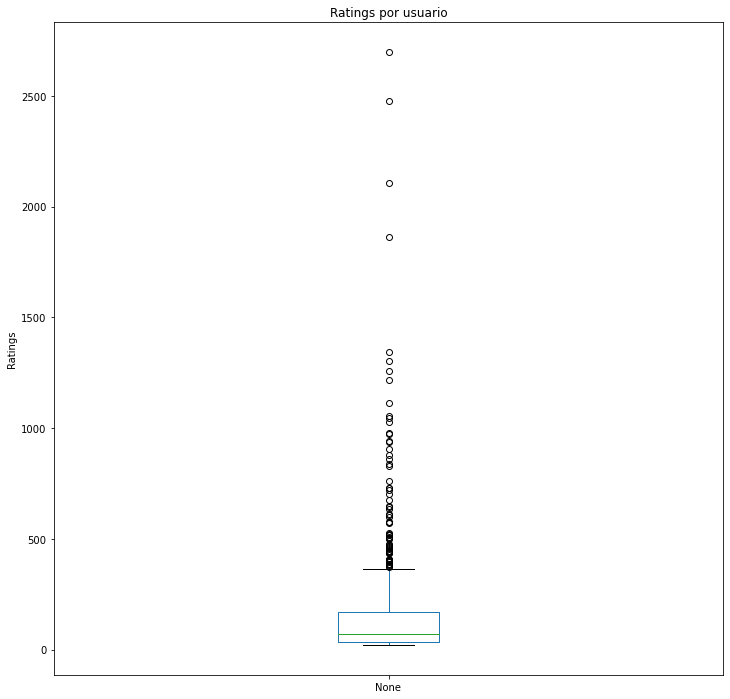

In [ ]:
#Crear boxplot con ratings por usuarios
ratepelixusuario = ratings.groupby("userId").size().sort_values(ascending=False)
ratepelixusuario .plot.box(figsize=(12,12), ylabel="Ratings", title='Ratings por usuario')

In [ ]:
#Promedio de calificaciones por usuario
ratepelixusuario = ratings.groupby("userId").size().count()
ratepelixusuario

610

In [ ]:
#Construir un dataset con los requisitos de votacion de los usuarios mayor a 10 y calificación de peliculas mayor a 100 
data1 = data1.loc[usuariovotos[usuariovotos > 10].index,:]
data1=data1.loc[:,peliculavotos[peliculavotos > 100].index]
data1

userId,1,4,6,7,10,15,17,18,19,20,...,599,600,601,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,2.5,4.5,3.5,4.0,0.0,...,3.0,2.5,4.0,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,...,2.5,4.0,0.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,4.5,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
176371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
177765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Operaciones en las columnas
csr_data = csr_matrix(data1.values)
data1.reset_index(inplace=True)

In [ ]:
#Modelo seleccionado con metrica de coseno porque permite calcular la distancia y computacionalmente es más rapida
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
#Función de recomendaciones
def get_movie_recommendation(Movie_id = list(movies['title'])):
    n_movies_to_reccomend = 10
    
    if len(Movie_id):
        Movie_id=movies[movies['title'].str.contains(Movie_id)]        
        movie_idx= Movie_id.iloc[0]['movieId']
        movie_idx = data1[data1['movieId'] == movie_idx].index[0]
        
        distances , indices = knn.kneighbors(csr_data[movie_idx],n_neighbors=n_movies_to_reccomend+1)    
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),\
                               key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = data1.iloc[val[0]]['movieId']
            idx =movies[movies['movieId'] == movie_idx].index
            recommend_frame.append({'Title':movies.iloc[idx]['title'].values[0],'Distance':val[1]})
        df = pd.DataFrame(recommend_frame,index=range(1,n_movies_to_reccomend+1))
        return df
    
    else:
        
        return "No movies found. Please check your input"

In [ ]:
#Obtener recomendaciones de películas con respecto al nombre ingresado
get_movie_recommendation('Spider-Man')

,Title,Distance
1,Pirates of the Caribbean: The Curse of the Bla...,0.285845
2,Shrek (2001),0.282840
3,"Lord of the Rings: The Return of the King, The...",0.275932
4,"Bourne Identity, The (2002)",0.273384
5,X-Men (2000),0.271716
6,Star Wars: Episode II - Attack of the Clones (...,0.260246
7,Minority Report (2002),0.256223
8,"Lord of the Rings: The Two Towers, The (2002)",0.255674
9,"Lord of the Rings: The Fellowship of the Ring,...",0.243543
10,Spider-Man 2 (2004),0.232026


In [ ]:
#Sistema de recomendación interactivo
print(interact(get_movie_recommendation))

interactive(children=(Dropdown(description='Movie_id', options=('Toy Story (1995)', 'Jumanji (1995)', 'Grumpie…

<function get_movie_recommendation at 0x00000268986E0C10>


In [ ]:
#Instalacion de paquetes
conda install -n notebook_env nb_conda_kernels
pip install -U ipykernel
conda install -c conda-forge scikit-surprise
pip install scikit-surprise

SyntaxError: invalid syntax (3637580900.py, line 2)

Sistema de recomendación basado en filtrado colaborativo

In [28]:
#Base de datos con movieId, title y ratings
InpMov = movie_ratings[['movieId','title','rating']]
InpMov

,movieId,title,rating
0,1,Toy Story (1995),4.0
1,3,Grumpier Old Men (1995),4.0
2,6,Heat (1995),4.0
3,47,Seven (a.k.a. Se7en) (1995),5.0
4,50,"Usual Suspects, The (1995)",5.0
...,...,...,...
100831,166534,Split (2017),4.0
100832,168248,John Wick: Chapter Two (2017),5.0
100833,168250,Get Out (2017),5.0
100834,168252,Logan (2017),5.0


In [29]:
#Base de datos de ratings sin timestamp
newrate = ratings.drop('timestamp',1)
newrate

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [30]:
#Filtrado de usuarios que han visto las peliculas 
visto = newrate[newrate['movieId'].isin(InpMov['movieId'].tolist())]
visto.head()


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [31]:
#Se crean diferentes dataframes donde usan el mismo vamor para el campo especificado
vistogroup = visto.groupby('userId')
vistogroup.get_group(300)

,userId,movieId,rating
45497,300,318,4.0
45498,300,356,4.0
45499,300,527,5.0
45500,300,593,4.0
45501,300,1172,5.0
45502,300,1704,3.0
45503,300,2028,4.0
45504,300,2324,5.0
45505,300,2329,4.0
45506,300,2571,4.0


In [32]:
#Se ordena para que los usuarios que hayan visto mas peliculas tengan prioridad 
vistogroup = sorted(vistogroup,  key=lambda x: len(x[1]), reverse=True)
#Observar un usuario
vistogroup[0:3]

[(414,
         userId  movieId  rating
  62294     414        1     4.0
  62295     414        2     3.0
  62296     414        3     4.0
  62297     414        5     2.0
  62298     414        6     3.0
  ...       ...      ...     ...
  64987     414   180045     4.0
  64988     414   180497     4.0
  64989     414   180985     3.5
  64990     414   184791     2.5
  64991     414   187595     3.5
  
  [2698 rows x 3 columns]),
 (599,
         userId  movieId  rating
  92623     599        1     3.0
  92624     599        2     2.5
  92625     599        3     1.5
  92626     599        6     4.5
  92627     599        7     2.5
  ...       ...      ...     ...
  95096     599   179817     3.0
  95097     599   180031     3.5
  95098     599   180297     3.0
  95099     599   181315     3.5
  95100     599   183301     3.0
  
  [2478 rows x 3 columns]),
 (474,
         userId  movieId  rating
  73092     474        1     4.0
  73093     474        2     3.0
  73094     474        5  

In [33]:
#Se elije un conjunto de usuarios 
vistogroup = vistogroup[0:100]

In [39]:
from math import sqrt

#La correlación de Pearson = diccionario 
PearsonCorrelation = {}
for name, group in vistogroup:
    group = group.sort_values(by='movieId')
    InpMov = InpMov.sort_values(by='movieId')
#Sacar N
    n = len(group)
#Obtener puntajes de revisión
    temp = InpMov[InpMov['movieId'].isin(group['movieId'].tolist())]
    tempRate = temp['rating'].tolist()
    tempGroup = group['rating'].tolist()
  #Calcular la Correlación Pearson entre dos usuarios, x e y
    Sxx = sum([i**2 for i in tempRate]) - pow(sum(tempRate),2)/float(n)
    Syy = sum([i**2 for i in tempGroup]) - pow(sum(tempGroup),2)/float(n)
    Sxy = sum( i*j for i, j in zip(tempRate, tempGroup)) - sum(tempRate)*sum(tempGroup)/float(n)
    if Sxx != 0 and Syy != 0:
        PearsonCorrelation[name] = abs(Sxy/(sqrt(abs(Sxx*Syy))))
    else:
        PearsonCorrelation[name] = 0
PearsonCorrelation.items()

dict_items([(414, 3.5725047975327557), (599, 3.1843317593919562), (474, 4.015574925046852), (448, 2.7164866070169715), (274, 4.197271322639705), (610, 4.22852458935279), (68, 3.571423616833853), (380, 3.7757414183681046), (606, 4.97820316163862), (288, 3.5912306187908856), (249, 5.427246279053577), (387, 3.742898770899147), (182, 3.467082711401886), (307, 2.405304438142573), (603, 2.9945782779879275), (298, 2.154164377906774), (177, 3.48440997869424), (318, 6.811529477629127), (232, 4.223213198651304), (480, 3.0955879563116757), (608, 2.8807593654347583), (600, 2.7659478100890658), (483, 3.742392818265607), (590, 3.9934683087881546), (105, 6.630716361913653), (19, 2.7828996732436893), (305, 4.238062760591358), (489, 2.50232157632811), (111, 3.0822645142847076), (438, 3.8359016917256303), (217, 3.123869603627063), (140, 4.293460055567537), (477, 3.997419484179637), (555, 3.1469056701688145), (91, 3.4713057459082344), (28, 3.7701545133726166), (219, 2.879410900445205), (534, 5.5755017118

In [35]:
#Calcular la correlación Pearson 
pearsonDF = pd.DataFrame.from_dict(PearsonCorrelation, orient='index')
pearsonDF.columns = ['Index Similar']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,Index Similar,userId
0,3.572747,414
1,3.184027,599
2,4.015708,474
3,2.716700,448
4,4.197076,274


In [57]:
UsuariosTop=pearsonDF.sort_values(by='Index Similar', ascending=False)[0:50]
UsuariosTop.head()

,Index Similar,userId
87,9.192428,122
97,7.023795,169
17,6.811574,318
24,6.630587,105
82,6.566194,425


In [58]:
UsuariosTopRate=UsuariosTop.merge(newrate, left_on='userId', right_on='userId', how='inner')
UsuariosTopRate.head()

,Index Similar,userId,movieId,rating
0,9.192428,122,2,4.0
1,9.192428,122,19,3.5
2,9.192428,122,32,5.0
3,9.192428,122,47,4.5
4,9.192428,122,50,5.0


In [59]:
#Se multiplica la similitud de los puntajes de los usuarios
UsuariosTopRate['Rating Peso'] = UsuariosTopRate['Index Similar']*UsuariosTopRate['rating']
UsuariosTopRate.head()

,Index Similar,userId,movieId,rating,Rating Peso
0,9.192428,122,2,4.0,36.769713
1,9.192428,122,19,3.5,32.173499
2,9.192428,122,32,5.0,45.962142
3,9.192428,122,47,4.5,41.365927
4,9.192428,122,50,5.0,45.962142


In [60]:
#Se aplica una suma a los topUsers luego de agruparlos por userId
tempTopUsersRating = UsuariosTopRate.groupby('movieId').sum()[['Index Similar','Rating Peso']]
tempTopUsersRating.columns = ['Suma Index Similar','Suma Rating Peso']
tempTopUsersRating.head()


,Suma Index Similar,Suma Rating Peso
movieId,,
1,171.139417,673.235296
2,140.997880,510.986643
3,27.902099,110.307902
4,8.900584,26.701752
5,51.406937,174.227488


In [61]:
rec_df = pd.DataFrame()
#Ahora se toma el promedio ponderado
rec_df['Peso promedio de recomendación'] = tempTopUsersRating['Suma Rating Peso']/tempTopUsersRating['Suma Index Similar']
rec_df['movieId'] = tempTopUsersRating.index
rec_df.head()


,Peso promedio de recomendación,movieId
movieId,,
1,3.933841,1
2,3.624073,2
3,3.953391,3
4,3.000000,4
5,3.389182,5


In [56]:
rec_df = rec_df.sort_values(by='Peso promedio de recomendación', ascending=False)
rec_df.head(10)

,Peso promedio de recomendación,movieId
movieId,,
72171,5.0,72171
179135,5.0,179135
84273,5.0,84273
117531,5.0,117531
74226,5.0,74226
4708,5.0,4708
7071,5.0,7071
3819,5.0,3819
171495,5.0,171495


In [49]:
recomendaciones = movies.loc[movies['movieId'].isin(recommendation_df.head(100)['movieId'].tolist())]
recomendaciones

,movieId,title,genres
161,190,Safe (1995),Thriller
259,299,Priest (1994),Drama
688,906,Gaslight (1944),Drama|Thriller
1350,1836,"Last Days of Disco, The (1998)",Comedy|Drama
1366,1866,"Big Hit, The (1998)",Action|Comedy|Crime
...,...,...,...
9396,164367,The Girl with All the Gifts (2016),Drama|Horror|Sci-Fi|Thriller
9423,165959,Alesha Popovich and Tugarin the Dragon (2004),Animation|Comedy|Drama
9514,171495,Cosmos,(no genres listed)
9634,179135,Blue Planet II (2017),Documentary


Sistema de recomendación basado en contenido

Con base en todo lo visto por el usuario

In [ ]:
#Tabla de movies
movies2.head(5)

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#De la base de datos movie_ratings se crea una base solo con las variables dummies de los generos
generos = movie_ratings1.drop('movieId',1).drop('title',1).drop('(no genres listed)',1).drop('userId',1).drop('rating',1).drop('timestamp',1)
generos

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
100832,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
100833,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
100834,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
movie_ratings1['rating']

0         4.0
1         4.0
2         4.0
3         5.0
4         5.0
         ... 
100831    4.0
100832    5.0
100833    5.0
100834    5.0
100835    3.0
Name: rating, Length: 100836, dtype: float64

In [ ]:
#Se usara el producto escalar para obtener los valores 
usuario = generos.transpose().dot(movie_ratings1['rating'])
usuario

Action         105629.0
Adventure       84771.5
Animation       25366.0
Children        31426.5
Comedy         132183.5
Crime           61024.0
Documentary      4629.5
Drama          153296.5
Fantasy         41312.5
Film-Noir        3410.5
Horror          23755.5
IMAX            14998.0
Musical         14746.5
Mystery         27875.5
Romance         63552.0
Sci-Fi          59587.0
Thriller        92415.5
War             18504.5
Western          6917.0
dtype: float64

In [ ]:
#Géneros de cada película al marco de datos original
tablaGeneros = movie_ratings1.set_index(movie_ratings1['movieId'])
#Se eliminan algunas columnas
tablaGeneros = tablaGeneros.drop('movieId', 1).drop('title', 1).drop('(no genres listed)', 1).drop('userId', 1).drop('rating', 1).drop('timestamp', 1)
tablaGeneros.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
47,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
50,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
#Operación de tabla de recomendaciones
TablaRecomendaciones = ((generos*usuario).sum(axis=1))/(usuario.sum())
TablaRecomendaciones.head()


0    0.326351
1    0.202750
2    0.268353
3    0.124602
4    0.187813
dtype: float64

In [ ]:
#Ordena nuestra recomendación en orden descendente
TablaRecomendaciones = TablaRecomendaciones.sort_values(ascending=False)
#Valores
TablaRecomendaciones.head()


100469    0.716053
29899     0.716053
34103     0.656169
25315     0.656169
67923     0.656169
dtype: float64

In [ ]:
#Tabla de recomendaciones final
movies.loc[movies['movieId'].isin(TablaRecomendaciones.head(100).keys())]

,movieId,title,genres
527,616,"Aristocats, The (1970)",Animation|Children
1323,1785,King of New York (1990),Crime|Thriller
3431,4675,Three Fugitives (1989),Action|Comedy
6771,60046,"Children of Huang Shi, The (2008)",Drama|War
6974,66371,Departures (Okuribito) (2008),Drama
7006,67923,"Fast & Furious (Fast and the Furious 4, The) (...",Action|Crime|Drama|Thriller
7816,92637,Pitfall (Otoshiana) (1962),Crime|Drama|Fantasy
7861,93980,"Three Stooges, The (2012)",Comedy
